In [1]:
import pandas as pd

# Load your dataset
file_path = "/kaggle/input/final1/tamil_grammar_large_dataset.csv"  # Update with your actual file path
df = pd.read_csv(file_path)

# Check the first few rows to understand the structure
print(df.head())

# Remove rows with any null values in the dataset
df_cleaned = df.dropna()

# Remove duplicate rows
df_cleaned = df_cleaned.drop_duplicates()

# Optionally, you can reset the index after cleaning
df_cleaned = df_cleaned.reset_index(drop=True)

# Check the cleaned dataset
print(df_cleaned.head())

# Save the cleaned dataset to a new CSV file
df_cleaned.to_csv("cleaned_dataset.csv", index=False)


                          Sentence              Error Type  \
0  அவர்கள் பள்ளிக்கு சாப்பிடுவாள்.          Spelling Error   
1     நாம் பாடத்தை படிக்கிறார்கள்.  Subject-Verb Agreement   
2     அவன் பள்ளிக்கு சாப்பிடுவாள்.          Spelling Error   
3    அவர்கள் பந்து விளையாடுகிறோம்.                No Error   
4  நான் புத்தகத்தை விளையாடுகிறான்.  Subject-Verb Agreement   

               Corrected Sentence  
0  அவர்கள் பள்ளிக்கு படிக்கிறாள்.  
1          நாம் பாடத்தை செல்வேன்.  
2  அவன் பள்ளிக்கு விளையாடுகிறோம்.  
3   அவர்கள் பந்து விளையாடுகிறோம்.  
4    நான் புத்தகத்தை படிக்கிறான்.  
                          Sentence              Error Type  \
0  அவர்கள் பள்ளிக்கு சாப்பிடுவாள்.          Spelling Error   
1     நாம் பாடத்தை படிக்கிறார்கள்.  Subject-Verb Agreement   
2     அவன் பள்ளிக்கு சாப்பிடுவாள்.          Spelling Error   
3    அவர்கள் பந்து விளையாடுகிறோம்.                No Error   
4  நான் புத்தகத்தை விளையாடுகிறான்.  Subject-Verb Agreement   

               Corrected Sentence  
0 

In [2]:
import os
os.environ["WANDB_MODE"] = "disabled"


In [3]:
import pandas as pd
from transformers import BartTokenizer, EncoderDecoderModel, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset


# Load the cleaned dataset
df_cleaned = pd.read_csv("cleaned_dataset.csv")

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df_cleaned, test_size=0.1)

# Convert the dataframe to Hugging Face dataset format
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
from transformers import MBart50Tokenizer, MBartForConditionalGeneration

# Load model and tokenizer
model_name = "facebook/mbart-large-50-many-to-one-mmt"  # Example multilingual model
tokenizer = MBart50Tokenizer.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name)

# Set the decoder_start_token_id
model.config.decoder_start_token_id = tokenizer.pad_token_id  # You can also use tokenizer.bos_token_id if available
model.config.pad_token_id = tokenizer.pad_token_id 
# Set the output_hidden_states flag to True



# Tokenizer function
def preprocess_function(examples):
    inputs = examples['Sentence']
    targets = examples['Corrected Sentence']
    
    # Tokenize the sentences (input and target)
    model_inputs = tokenizer(inputs, max_length=10, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=10, truncation=True, padding="max_length")
    
    # Add the labels to the model inputs
    model_inputs["labels"] = labels["input_ids"]
    
    return model_inputs

# Apply tokenization on train and validation datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",          # Output directory
    eval_strategy="epoch",           # Evaluation after each epoch
    learning_rate=5e-5,              # Learning rate
    per_device_train_batch_size=16,   # Batch size for training
    per_device_eval_batch_size=16,    # Batch size for evaluation
    num_train_epochs=10,              # Number of training epochs
    weight_decay=0.01,               # Weight decay to avoid overfitting
    save_total_limit=2,              # Limit on the number of saved checkpoints
    logging_dir="./logs",
    warmup_steps=int(0.1 * len(train_dataset)),
    lr_scheduler_type="linear",
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    run_name="tamil-error-correction",
    report_to=[]
    # Specify a unique run name
)

# Create Trainer with WandB tracking
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,  # Make sure the tokenizer is passed for padding, truncation
    data_collator=None,
)

# Train the model
trainer.train()

# Save the trained model
trainer.save_model("trained_model")

# Optionally, evaluate the model on validation set
results = trainer.evaluate(val_dataset)
print(results)


tokenizer_config.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/268 [00:00<?, ?B/s]

Map:   0%|          | 0/1775 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

<ipython-input-3-023ee54606b6>:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,2.904040
2,No log,1.264648
3,No log,0.801584
4,No log,0.248768
5,No log,0.178257
6,No log,0.161620
7,No log,0.156355
8,No log,0.147738
9,No log,0.146722
10,No log,0.146692


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'num_beams': 5, 'forced_bos_token_id': 250004}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.14669166505336761, 'eval_runtime': 2.2448, 'eval_samples_per_second': 88.203, 'eval_steps_per_second': 3.118, 'epoch': 10.0}


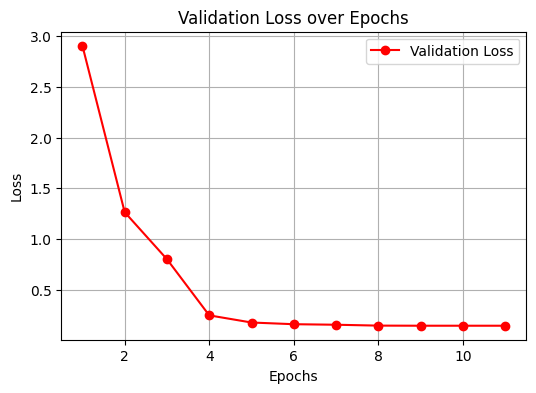

In [5]:
import matplotlib.pyplot as plt

# Extract logs from Trainer state
log_history = trainer.state.log_history

# Separate training and validation losses
train_losses = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_losses = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
learning_rates = [entry['learning_rate'] for entry in log_history if 'learning_rate' in entry]

# Create x-axis for epochs

epochs_eval = range(1, len(eval_losses) + 1)

# Plot validation loss
plt.figure(figsize=(6, 4))
plt.plot(epochs_eval, eval_losses, label="Validation Loss", marker='o', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss over Epochs")
plt.legend()
plt.grid()
plt.show()




In [6]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
from nltk.translate.bleu_score import sentence_bleu


# Check if GPU is available and move the model to GPU if it is
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Generate predictions on the validation set
predictions = []
references = []

# Use the model to generate predictions on the validation set
for example in val_dataset:
    input_ids = tokenizer(example['Sentence'], return_tensors='pt', padding=True, truncation=True, max_length=35).input_ids
    
    # Move input_ids to the correct device (same as the model)
    input_ids = input_ids.to(device)
    
    output_ids = model.generate(input_ids)
    decoded_prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)  # Use tokenizer's decode method

    predictions.append(decoded_prediction)
    references.append(example['Corrected Sentence'])

# BLEU Score Calculation (with n-gram overlap)
def calculate_bleu(predictions, references):
    bleu_scores = []
    for pred, ref in zip(predictions, references):
        # Tokenize sentences and calculate BLEU score
        pred_tokens = pred.split()
        ref_tokens = ref.split()
        bleu_scores.append(sentence_bleu([ref_tokens], pred_tokens))  # List of references is passed to sentence_bleu
    return sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0


# Calculate BLEU
bleu_score = calculate_bleu(predictions, references)


# Print the results
print(f"BLEU Score: {bleu_score:.4f}")



BLEU Score: 0.8181


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [7]:
!pip install bert_score
from bert_score import score
P, R, F1 = score(predictions, references, lang="ta")  # Adjust the language if necessary (e.g., "ta" for Tamil)

# Print BERT scores
print(f"BERT Precision: {P.mean():.4f}")
print(f"BERT Recall: {R.mean():.4f}")
print(f"BERT F1 Score: {F1.mean():.4f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.2 MB/s eta 0:00:00


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BERT Precision: 0.8766
BERT Recall: 0.8947
BERT F1 Score: 0.8851


In [8]:
import nltk

def calculate_ter(references, predictions):
    """
    Compute TER (Translation Edit Rate) score.
    references: list of reference sentences (the correct sentences)
    predictions: list of generated sentences (the sentences predicted by the model)
    """
    # Initialize the TER scores
    ter_scores = []
    
    # Loop over all the sentences
    for ref, hyp in zip(references, predictions):
        ref_tokens = ref.split()  # Tokenize the reference sentence
        hyp_tokens = hyp.split()  # Tokenize the hypothesis sentence

        # Find the minimum edit distance (substitutions, insertions, deletions)
        edits = nltk.edit_distance(ref_tokens, hyp_tokens)

        # TER is calculated as (number of edits + len(reference) - len(hypothesis)) / len(reference)
        ter = (edits + len(ref_tokens) - len(hyp_tokens)) / len(ref_tokens)
        ter_scores.append(ter)

    # Average TER score across all sentences
    avg_ter = sum(ter_scores) / len(ter_scores) if ter_scores else 0
    return avg_ter



ter_score = calculate_ter(references, predictions)
print(f"TER Score: {ter_score:.4f}")


TER Score: 0.2525


In [9]:
import nltk
from collections import Counter

def calculate_gleu(references, predictions, max_order=4):
    """
    Compute GLEU score.
    references: list of reference sentences (the correct sentences)
    predictions: list of generated sentences (the sentences predicted by the model)
    max_order: maximum n-gram length for the BLEU calculation (default is 4)
    """
    def get_ngrams(tokens, n):
        return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

    def compute_sentence_gleu(ref_tokens, hyp_tokens):
        """
        Compute the GLEU score for a single sentence pair.
        """
        total_ref_ngrams = Counter()
        total_hyp_ngrams = Counter()
        total_match_ngrams = Counter()

        for n in range(1, max_order + 1):
            ref_ngrams = get_ngrams(ref_tokens, n)
            hyp_ngrams = get_ngrams(hyp_tokens, n)
            
            ref_ngrams_count = Counter(ref_ngrams)
            hyp_ngrams_count = Counter(hyp_ngrams)

            total_ref_ngrams.update(ref_ngrams_count)
            total_hyp_ngrams.update(hyp_ngrams_count)
            total_match_ngrams.update(ref_ngrams_count & hyp_ngrams_count)  # Intersection for matching n-grams

        # Compute precision and recall
        precision = sum(total_match_ngrams.values()) / sum(total_hyp_ngrams.values()) if total_hyp_ngrams else 0
        recall = sum(total_match_ngrams.values()) / sum(total_ref_ngrams.values()) if total_ref_ngrams else 0

        # Compute GLEU score (harmonic mean of precision and recall)
        if precision + recall > 0:
            gleu = (1 + 0.5) * (precision * recall) / (0.5 * precision + recall)
        else:
            gleu = 0
        return gleu

    # Initialize the GLEU scores
    gleu_scores = []

    # Loop over all reference-prediction pairs
    for ref, hyp in zip(references, predictions):
        ref_tokens = ref.split()  # Tokenize the reference sentence
        hyp_tokens = hyp.split()  # Tokenize the hypothesis sentence

        gleu_score = compute_sentence_gleu(ref_tokens, hyp_tokens)
        gleu_scores.append(gleu_score)

    # Average GLEU score across all sentences
    avg_gleu = sum(gleu_scores) / len(gleu_scores) if gleu_scores else 0
    return avg_gleu

gleu_score = calculate_gleu(references, predictions)
print(f"GLEU Score: {gleu_score:.4f}")


GLEU Score: 0.6212


In [10]:
import random
import torch
from nltk.translate.bleu_score import sentence_bleu

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 1: Select 5 random samples from val_dataset
random_samples = random.sample(list(val_dataset), 5)

# Step 2: Generate predictions and store results
predictions = []
references = []

for sample in random_samples:
    incorrect_sentence = sample['Sentence']
    corrected_sentence = sample['Corrected Sentence']

    # Tokenize the incorrect sentence
    inputs = tokenizer(incorrect_sentence, return_tensors="pt", padding=True, truncation=True, max_length=50)

    # Move inputs to the correct device
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Generate prediction
    with torch.no_grad():
        outputs = model.generate(input_ids=inputs['input_ids'], max_length=50, num_beams=4, early_stopping=True)

    # Decode predicted sentence
    predicted_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Store results
    predictions.append(predicted_sentence)
    references.append(corrected_sentence)

    # Print each sample
    print("\n--- Sample ---")
    print(f"Incorrect Sentence: {incorrect_sentence}")
    print(f"Corrected Sentence: {corrected_sentence}")
    print(f"Predicted Sentence: {predicted_sentence}")

# Step 3: BLEU Score Calculation
def calculate_bleu(predictions, references):
    bleu_scores = []
    for pred, ref in zip(predictions, references):
        pred_tokens = tokenizer.tokenize(pred)  # Use model's tokenizer
        ref_tokens = tokenizer.tokenize(ref)  # Use model's tokenizer
        bleu_scores.append(sentence_bleu([ref_tokens], pred_tokens))  # List of references needed
    return sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0

# Compute BLEU score
average_bleu = calculate_bleu(predictions, references)
print(f"\n✅ Average BLEU Score (5 samples): {average_bleu:.4f}")



--- Sample ---
Incorrect Sentence: அவள் பாடத்தை விளையாடுகிறான்.
Corrected Sentence: அவள் பாடத்தை படிக்கிறாள்.
Predicted Sentence: அவள் பாடத்தை சாப்பிடுகிறான்.

--- Sample ---
Incorrect Sentence: அவன் பாடத்தை படிக்கிறான்.
Corrected Sentence: அவன் பாடத்தை படிக்கிறான்.
Predicted Sentence: அவன் பாடத்தை படிக்கிறான்.

--- Sample ---
Incorrect Sentence: நாம் பந்து விளையாடுகிறான்.
Corrected Sentence: நாம் பந்து படிக்கிறாள்.
Predicted Sentence: நாம் பந்து சாப்பிடுகிறான்.

--- Sample ---
Incorrect Sentence: அவர்கள் பந்து செல்கிறான்.
Corrected Sentence: அவர்கள் பந்து படிக்கிறான்.
Predicted Sentence: அவர்கள் பந்து செல்வேன்.

--- Sample ---
Incorrect Sentence: அவள் பாடத்தை விளையாடுகிறோம்.
Corrected Sentence: அவள் பாடத்தை விளையாடுகிறோம்.
Predicted Sentence: அவள் பாடத்தை விளையாடுகிறோம்.

✅ Average BLEU Score (5 samples): 0.6627


In [11]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.5 MB/s eta 0:00:00


In [22]:
import torch
import nltk
import sacrebleu
from nltk.translate.bleu_score import sentence_bleu

# Ensure nltk package is ready
nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Tamil samples with similar errors
tamil_samples = [
    # 5-word sentences (5 samples)
    {"incorrect": "அன்பு பாராட்டு செய்தார் மக்கள் முன்னிலையில்", "corrected": "அன்புப் பாராட்டு செய்தார் மக்கள் முன்னிலையில்"},
    {"incorrect": "நடிகர் பேசினார் ரசிகர்கள் கூட்டத்தில்", "corrected": "நடிகர் பேசினார் ரசிகர்கள் கூட்டத்தில்"},

    # 4-word sentences (8 samples)
    {"incorrect": "மழை காரணம் வெள்ளம் ஏற்பட்டது", "corrected": "மழை காரணமாக வெள்ளம் ஏற்பட்டது"},
    {"incorrect": "நாடு முன்னேற்ற வளர்ச்சி இன்றியமையாது", "corrected": "நாடு முன்னேற்றம் வளர்ச்சி இன்றியமையாது"},
    {"incorrect": "அவன் விரைவில் சென்று விட்டான்", "corrected": "அவன் விரைவாக சென்று விட்டான்"},
    {"incorrect": "படிப்பு முடித்த வேலை பெற்றான்", "corrected": "படிப்பு முடித்து வேலை பெற்றான்"},
    {"incorrect": "மகிழ்ச்சி உணர்வு மனதை உற்சாகம்", "corrected": "மகிழ்ச்சி உணர்வு மனதை உற்சாகம்"},

    # 3-word sentences (2 samples)
    {"incorrect": "நான் பெற்ற மதிப்பெண்", "corrected": "நான் பெற்ற மதிப்பெண்கள்"},
]

total_bleu_score = 0.0  # Store cumulative BLEU score
total_ter_score = 0.0   # Store cumulative TER score
num_samples = len(tamil_samples)

for sample in tamil_samples:
    incorrect_sentence = sample["incorrect"]
    corrected_sentence = sample["corrected"]

    # Tokenize the incorrect sentence
    inputs = tokenizer(incorrect_sentence, return_tensors="pt")

    # Move inputs to the same device as the model (GPU if available)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Generate the predicted sentence
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            max_length=50,
            num_beams=5,  
            temperature=0.7,  
            top_k=50, 
            top_p=0.9,
            early_stopping=True
        )

    # Decode the predicted sentence
    predicted_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Compute BLEU score
    reference = [nltk.word_tokenize(corrected_sentence)]
    candidate = nltk.word_tokenize(predicted_sentence)
    bleu_score = sentence_bleu(reference, candidate, weights=(0.5, 0.5))  # Bi-gram BLEU score
    total_bleu_score += bleu_score

    # Compute TER score using sacrebleu
    # Compute TER score using sacrebleu
    ter_score = sacrebleu.sentence_ter(predicted_sentence, [corrected_sentence]).score
    total_ter_score += ter_score  # Extract the score before adding


    # Print results
    print("\nIncorrect Sentence:", incorrect_sentence)
    print("Corrected Sentence:", corrected_sentence)
    print("Predicted Sentence:", predicted_sentence)
    print("BLEU Score: {:.2f}".format(bleu_score))
    print("TER Score: {:.2f}".format(ter_score))

# Compute the average BLEU and TER scores
average_bleu_score = total_bleu_score / num_samples
average_ter_score = total_ter_score / num_samples

print("\nAverage BLEU Score: {:.2f}".format(average_bleu_score))
print("Average TER Score: {:.2f}".format(average_ter_score))


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

Incorrect Sentence: அன்பு பாராட்டு செய்தார் மக்கள் முன்னிலையில்
Corrected Sentence: அன்புப் பாராட்டு செய்தார் மக்கள் முன்னிலையில்
Predicted Sentence: அன்பு படிக்கிறாள் மக்கள் முன்னிலை விளையாடுகிறோம்.
BLEU Score: 0.41
TER Score: 100.00

Incorrect Sentence: நடிகர் பேசினார் ரசிகர்கள் கூட்டத்தில்
Corrected Sentence: நடிகர் பேசினார் ரசிகர்கள் கூட்டத்தில்
Predicted Sentence: Actor பேசினார் சாப்பிடுகிறான்கிறான்
BLEU Score: 0.41
TER Score: 75.00

Incorrect Sentence: மழை காரணம் வெள்ளம் ஏற்பட்டது
Corrected Sentence: மழை காரணமாக வெள்ளம் ஏற்பட்டது
Predicted Sentence: மழை படிக்கிறாள் செல்வேன்.
BLEU Score: 0.50
TER Score: 75.00

Incorrect Sentence: நாடு முன்னேற்ற வளர்ச்சி இன்றியமையாது
Corrected Sentence: நாடு முன்னேற்றம் வளர்ச்சி இன்றியமையாது
Predicted Sentence: நாடு சாப்பிடுகிறான் சாப்பிடுகிறான்.
BLEU Score: 0.50
TER Score: 75.00

Incorrect Sentence: அவன் விரைவில் சென்று விட்டான்
Cor